#Digital Twin Winter Wheat

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Smart-Droplets-Project/digitalTwinFramework/blob/main/Digital-Twin.ipynb)

This notebook shows some aspects of a digital twin of winter wheat.

**Functional components**

The employed digital twins consist of two functional components:
1.   *Monitoring*: A digital representation of the crops, as generated by a crop growth model
2.   *Controlling*: An AI agent that ingests the state of the crop and transforms that into an action (i.e. farm management operation (e.g. fertilization))

<figure>
<img width="600" height="285" src='https://drive.google.com/uc?id=1u_tiGJX1vLPoCdVX8_1R7J6dpnKxi8CL' />
</figure>


**Workflow**

The workflow consists of the following steps:

1. *Start of the season:* initialize crop growth model
2. *In-season:*
    1. Use data on "driving variables" (e.g. weather) and "agromanagement actions" to progress crop growth model
    2. Ask AI agent for fertilizer recommendation
    3. (optional) Assimilate collected data into crop growth model

<figure>
<img width="600" height="285" src='https://drive.google.com/uc?id=17FV4nHb-fLrhsTWnVAfeXu5MogwMZEk1' />
</figure>

In [ ]:
# setup environment:
# install interface to crop growth model (pcse)
!pip install pcse=="5.5.6" --quiet
# install onx for deployment of RL agent
!pip install onnx onnxruntime --quiet

# clone library with configurations (pcse-gym)
!git clone https://github.com/BigDataWUR/PCSE-Gym.git

import sys
sys.path += ['/content/pcse','/content/PCSE-Gym/']
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Downgrade NumPy to a version compatible with PCSE (e.g. 1.26)
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir

# Note: You must restart the runtime in order to use the correct numpy version.

**Initialize crop growth model**

Set parameters for crop, site, and soil. Parameters have been calibrated for a field of Winter Wheat in Lithuania

In [3]:
import pandas as pd
import datetime
import pcse
import yaml
import os

location = (55.5, 23.5) #Lithuania
year=2023

# set config for crop growth model
config_dir='/content/PCSE-Gym/pcse_gym/envs/configs'
crop_parameters=pcse.fileinput.PCSEFileReader(os.path.join(config_dir,'crop','lintul3_winterwheat.crop'))
site_parameters=pcse.fileinput.PCSEFileReader(os.path.join(config_dir,'site','lintul3_springwheat.site'))
soil_parameters=pcse.fileinput.PCSEFileReader(os.path.join(config_dir,'soil','lintul3_springwheat.soil'))

# store configs in parameter_provider
parameter_provider = pcse.base.ParameterProvider(cropdata=crop_parameters, sitedata=site_parameters, soildata=soil_parameters)

# define start and end date of simulation: the season runs from 01/01/2023 till 31/12/2023
# the crop has been sown in fall 2022; at the start of our simulation the crop has already emerged
# the initial amount of biomass is set with the state variable "WLVGI"

agro_config=os.path.join(config_dir, 'agro', 'agromanagement_fertilization.yaml')
with open(agro_config, 'r') as f:
    agro_management = yaml.load(f, Loader=yaml.SafeLoader)
    agro_key = list(agro_management[0].keys())[0]
    new_agro_key = datetime.date(year, 1, 1)
    agro_management[0][new_agro_key] = agro_management[0].pop(agro_key)
    agro_management[0][new_agro_key]['CropCalendar']['crop_start_date']= datetime.date(year, 1, 1)
    agro_management[0][new_agro_key]['CropCalendar']['crop_end_date']= datetime.date(year, 12, 31)

model_config=os.path.join(config_dir, 'Lintul3.conf')

**Initialize collection of driving variable "weather"**

The crop growth model needs daily weather input. PCSE has some [routines](https://pcse.readthedocs.io/en/stable/reference_guide.html#weather-data-in-pcse) to extract weather info from e.g. NASAPower.
We prefer to delegate this task to the data management platform, however. The following setup allows us to "inject" weather data (collected by the data management platform) into the PCSE engine.

In [5]:
# get weather data from NASAPower and store in data frame
# we then can extract weather data from this data frame as if it were obtained from the data management platform
nasapower = pcse.db.NASAPowerWeatherDataProvider(*location)
weather_df = pd.DataFrame(nasapower.export())

class DMPWeatherProvider(pcse.base.weather.WeatherDataProvider):
    def add(self, weather_dict):
        wdc = pcse.base.weather.WeatherDataContainer(**weather_dict)
        self._store_WeatherDataContainer(wdc, weather_dict['DAY'])

def get_weather(df, day):
    return df.loc[df['DAY'] == day].to_dict(orient='records')[0]

# some helper functions that we will use later on
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

# to_obs converts state variables of (1) the crop growth model (2) weather data to a "tensor" that can be fed to the AI agent
def to_obs(crop_data, weather_data):
    crop_variables = ["DVS", "TGROWTH", "LAI", "NUPTT", "TRAN", "TNSOIL", "TRAIN", "TRANRF", "WSO"]
    weather_variables = ["IRRAD", "TMIN", "RAIN"]
    timestep = 7

    obs = np.zeros(len(crop_variables) + timestep*len(weather_variables))
    for i, feature in enumerate(crop_variables):
      obs[i] = crop_data[feature]

    for d in range(timestep):
      for i, feature in enumerate(weather_variables):
        j = d * len(weather_variables) + len(crop_variables) + i
        obs[j] = getattr(weather_data[d], feature)
    return obs

**In season: crop growth simulation with AI agent**

We start our simulation at 01/01/23, then we progress in daily timesteps till the end of the season (i.e. 01/10/23).

Every day we collect data on the weather and use that to progress the crop growth model. Every week we ask the AI agent for a recommendation on fertilizer application.
Once we get observations from the field we use data assimilation to update the crop growth model. The latter step is not shown in this notebook.

In [6]:
import onnx
import onnxruntime as ort
import numpy as np

# start AI agent: load model from disk
pcse_gym_path='/content/PCSE-Gym'
ai_agent_path = os.path.abspath(os.path.join(pcse_gym_path,'tests', 'model-1.onnx'))
ort_sess = ort.InferenceSession(ai_agent_path)

# start digital twin
weather_data_provider = DMPWeatherProvider()
weather_data_provider.add(get_weather(weather_df, datetime.date(year, 1, 1)))
crop_growth_model = pcse.engine.Engine(parameter_provider, weather_data_provider, agro_management, config=model_config)
first_date = crop_growth_model.get_output()[-1]['day']

recovery_rate = 0.7 #parameter to specify fraction of fertilizer that becomes available for the crop
for single_date in daterange(datetime.date(year, 1, 1), datetime.date(year, 10, 31)):
    # get weather from container
    weather_dict = get_weather(weather_df, single_date+datetime.timedelta(days=1))
    # "inject" weather data in PCSE engine (via weather_data_provider class)
    weather_data_provider.add(weather_dict)
    # run engine for one day
    crop_growth_model.run(days=1)

    # apply some management actions (e.g. fertilization)
    if (single_date - first_date).days % 7 ==0 and single_date > (first_date + datetime.timedelta(days=7)):
      crop_data = crop_growth_model.get_output()[-1]
      weather_data = [crop_growth_model.weatherdataprovider(day) for day in daterange(crop_data['day']-datetime.timedelta(days=7), crop_data['day'])]
      # collect crop_status and weather_status and feed to AI agent
      obs = np.array([to_obs(crop_data, weather_data)])
      action_probs = ort_sess.run(None, {"input": obs.astype(np.float32)})
      # interpret action returned from AI agent
      amount = 2 * np.argmax(action_probs)
      if np.argmax(action_probs) !=0: print(f'{single_date}: apply {amount*10} kg/ha')
      # feed back action AI agent to crop growth model
      crop_growth_model._send_signal(signal=pcse.signals.apply_n, N_amount=amount * 10, N_recovery=recovery_rate,
                                  amount=amount, recovery=recovery_rate)

#collect output
model_output = pd.DataFrame(crop_growth_model.get_output())
model_output = model_output.set_index("day")

2023-02-26: apply 40 kg/ha
2023-03-12: apply 40 kg/ha
2023-03-19: apply 40 kg/ha
2023-03-26: apply 40 kg/ha
2023-04-02: apply 40 kg/ha
2023-04-16: apply 40 kg/ha
2023-04-23: apply 20 kg/ha
2023-04-30: apply 40 kg/ha
2023-05-07: apply 20 kg/ha
2023-05-14: apply 20 kg/ha
2023-05-28: apply 20 kg/ha


**Baseline for comparison: crop growth simulation with** ***Standard Practice Agent***

Here we show what what happens with a "Standard Practice" fertilization scheme. In this scheme 90kg of fertilizer is applied twice, at 01/03/2023 and 01/04/2023.

In [7]:
crop_growth_model_with_standard_practice = pcse.engine.Engine(parameter_provider, weather_data_provider, agro_management, config=model_config)
for single_date in daterange(datetime.date(year, 1, 1), datetime.date(year, 10, 31)):
    # get weather from container
    weather_dict = get_weather(weather_df, single_date+datetime.timedelta(days=1))
    # "inject" weather data in PCSE engine (via weather_data_provider class)
    weather_data_provider.add(weather_dict)
    # run engine for one day
    crop_growth_model_with_standard_practice.run(days=1)
    # apply some management actions (e.g. fertilization)

    amount = 9 #(9g/m2=90kg/ha)
    if single_date==datetime.date(year, 3, 1) or single_date==datetime.date(year, 4, 1):
      crop_growth_model_with_standard_practice._send_signal(signal=pcse.signals.apply_n, N_amount=amount * 10, N_recovery=recovery_rate,
                                      amount=amount, recovery=recovery_rate)

#collect output
model_output_standard_practice = pd.DataFrame(crop_growth_model_with_standard_practice.get_output())
model_output_standard_practice = model_output_standard_practice.set_index("day")

**Visualize output crop growth model**

Here we visualize the crop growth under two policies: (1) AI agent, and (2) Standard Practice.

<ipython-input-8-945184663>:23: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(model_output_standard_practice.index, model_output_standard_practice[var], 'r-', label='Standard Practice')
<ipython-input-8-945184663>:24: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(model_output.index, model_output[var], 'b-', label='AI agent')


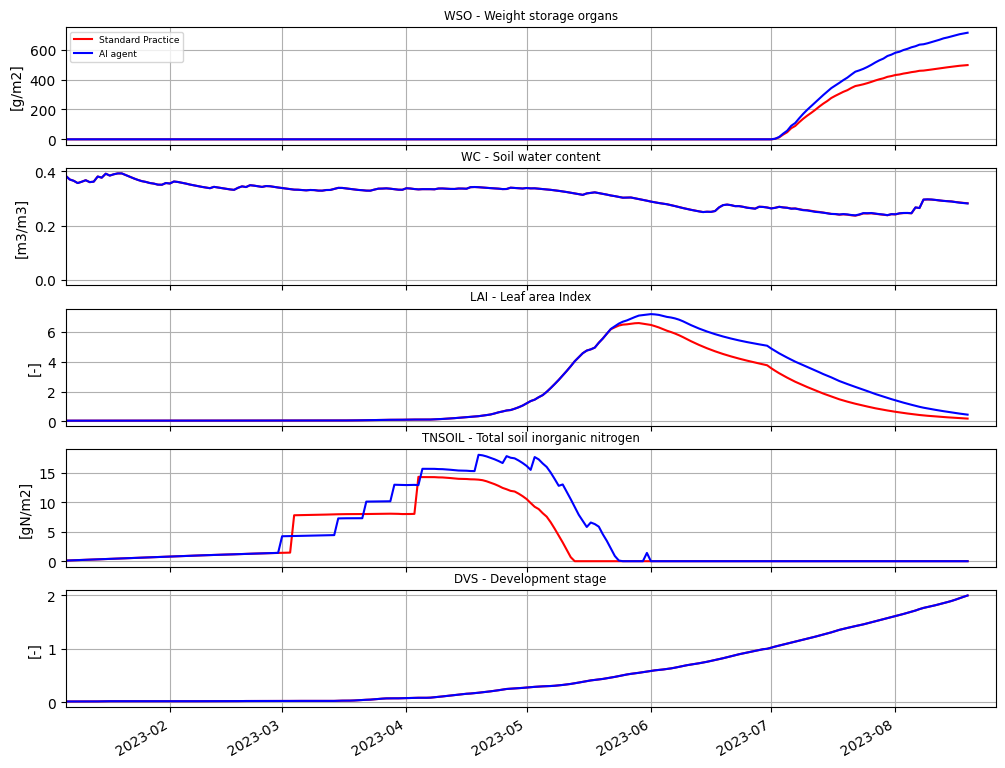

In [8]:
# visualize crop growth model
import matplotlib
import matplotlib.pyplot as plt

titles = {"DVS":("Development stage", "-"),
          "TGROWTH": ("Total biomass (above and below ground)", "g/m2"),
          "LAI": ("Leaf area Index", "-"),
          "NUPTT": ("Total nitrogen uptake", "gN/m2"),
          "TRAN": ("Transpiration", "mm/day"),
          "TNSOIL": ("Total soil inorganic nitrogen", "gN/m2"),
          "TRAIN": ("Total rainfall", "mm"),
          "TRANRF": ("Transpiration reduction factor", "-"),
          "TAGBM": ("Total aboveground biomass", "g/m2"),
          "TTRAN": ("Total transpiration", "mm"),
          "WC": ("Soil water content", "m3/m3"),
          "WSO": ("Weight storage organs", "g/m2")
         }

plot_variables = ["WSO", "WC", "LAI", "TNSOIL","DVS"]
fig, axes = plt.subplots(len(plot_variables), 1, sharex=True, figsize=(12,10))
for i, var in enumerate(plot_variables):
    ax = axes if len(plot_variables) == 1 else axes[i]
    ax.plot_date(model_output_standard_practice.index, model_output_standard_practice[var], 'r-', label='Standard Practice')
    ax.plot_date(model_output.index, model_output[var], 'b-', label='AI agent')
    name, unit = titles[var]
    title = f"{var} - {name}"
    ax.set_ylabel(f"[{unit}]")
    ax.set_title(title, fontsize="8.5")
    if i==0: ax.legend(fontsize="6.5")
    ax.grid()
ax.set_xlim([model_output.index[5], model_output.index[-1]+ datetime.timedelta(days=7)])
fig.autofmt_xdate()